In [1]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

seed = 22
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the device to custom GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
gpu = gpus[0] # Specify which gpu to use here. Can run multiple scripts on different GPUs
if gpu:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
        print("CUDA is available!")
        print("Number of available GPUs:", len(gpus))
        print("Current GPU:", gpu)
    except RuntimeError as e:
        print(e)
else:
    print("CUDA is not available. Running on CPU.")

2024-07-29 13:12:32.107733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 13:12:32.148612: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CUDA is available!
Number of available GPUs: 1
Current GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-07-29 13:12:33.726021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:12:33.739244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:12:33.739343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Set to directory where data is stored
work_home = True
data_dir = "../Datasets" if work_home else "/cephfs/dice/projects/L1T/diffusion/datasets/"
import os
print(os.getcwd())

start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(end_idx-start_idx, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx) # 120 eta, 72 phi

/home/themrluke/projects/stablediffusion/keras_version


In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:Loading .npy files from /home/themrluke/projects/stablediffusion/keras_version/signal.npy and /home/themrluke/projects/stablediffusion/keras_version/pile_up.npy


Show original shape of image to determine which axis corresponds to eta and phi:

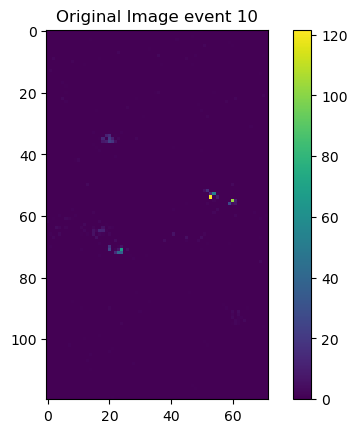

In [4]:

# Select an index for the image you want to visualize
testEvent = 10  # Change this to visualize a different image

# Access the original image from the dataset
original_image = dataset.signal[testEvent]

# Display the original image using matplotlib
plt.imshow(original_image)
plt.colorbar()
plt.title(f"Original Image event {testEvent}")
plt.show()


In [5]:
new_dim=(64,64)

saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(new_dim)     # ensure these have the same values as when the model was trained

INFO:root:Re-sizing tensors...


In [6]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

# Change size of strip here
strip_top = 26
strip_bottom = 38

MSE_y_start = strip_top
MSE_y_end = strip_bottom

if strip_size == 'strip':
    y_start = strip_top
    y_end = strip_bottom
    
elif strip_size == 'full_image':
    y_start = 0
    y_end = 64

In [7]:
# Convert data to TensorFlow tensors
clean_frames = tf.convert_to_tensor(dataset.signal, dtype=tf.float32)[:, y_start:y_end, :]
pile_up = tf.convert_to_tensor(dataset.pile_up, dtype=tf.float32)[:, y_start:y_end, :]

# Normalize data
clean_frames = tf.clip_by_value(clean_frames, 0, saturation_value)
pile_up = tf.clip_by_value(pile_up, 0, saturation_value)

# Reshape data
clean_frames = tf.expand_dims(clean_frames, axis=-1)
pile_up = tf.expand_dims(pile_up, axis=-1)

print(clean_frames.shape)

(300, 64, 64, 1)


2024-07-29 13:12:34.364938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 13:12:34.366876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:12:34.366907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-29 13:12:34.366919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/de

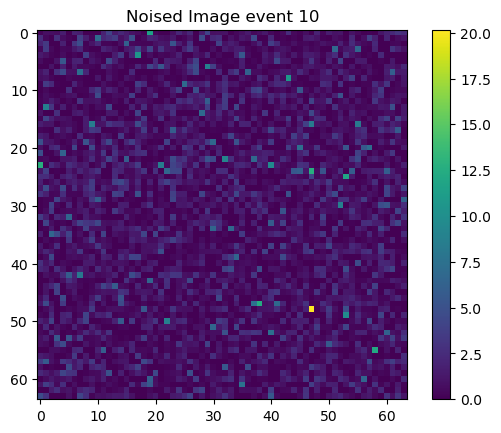

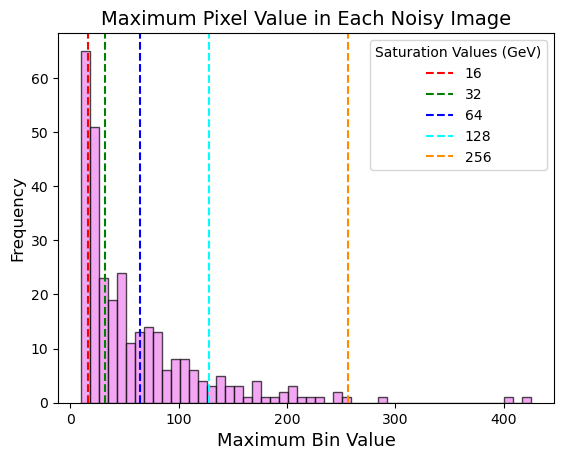

Threshold (GeV)      Perc of Events Above Threshold(%)
16                   82.00                    
32                   56.00                    
64                   33.33                    
128                  11.67                    
256                  1.33                     
512                  0.00                     


In [8]:
batch_size = 100
dataloader = tf.data.Dataset.from_tensor_slices(clean_frames).batch(batch_size)

# Create noise scheduler
noise_scheduler = NoiseScheduler('pile-up')

# Each unit of timestep represents an additional 5 pile-up events (max 40 = 200PU)
timestep = tf.convert_to_tensor(40)

# Initialize the array to hold the maximum pixel values
noisy_max_bin = np.zeros(end_idx - start_idx)

# Loop through the DataLoader
for batch_idx, clean_batch in enumerate(dataloader):
    random_seed = np.random.randint(0, end_idx - start_idx)

    # Generate the noisy image at maxTimestep (200 pile-ups)
    noisy_images, noise = noise_scheduler.add_noise(
        clean_frame=clean_batch, 
        noise_sample=pile_up, 
        timestep=timestep, 
        random_seed=random_seed, 
        n_events=end_idx - start_idx
    )

    # Update the maximum pixel values
    batch_start = batch_idx * batch_size # GOT TO HERE
    batch_end = batch_start + clean_batch.shape[0]
    
    # Calculate the maximum pixel value for each image in the batch
    noisy_max_bin[batch_start:batch_end] = tf.reduce_max(tf.reshape(noisy_images, (noisy_images.shape[0], -1)), axis=1).numpy()

    # Visualize one image from the batch (e.g., the first image in the batch)
    if batch_idx == 0:  # Adjust condition to visualize other batches if needed
        plt.imshow(noisy_images[testEvent].numpy().squeeze())
        plt.colorbar()
        plt.title(f"Noised Image event {testEvent}")
        plt.show()

# Plot histogram to see distribution of maximum pixel value in each event
plt.hist(noisy_max_bin, bins=50, color='violet', alpha=0.7, edgecolor='black')
plt.title('Maximum Pixel Value in Each Noisy Image', fontsize=14)
plt.xlabel('Maximum Bin Value', fontsize=13)
plt.ylabel('Frequency', fontsize=12)
# Plot vertical lines at x values of 16, 32, 64
plt.axvline(x=16, color='r', linestyle='--', label='16')
plt.axvline(x=32, color='green', linestyle='--', label='32')
plt.axvline(x=64, color='blue', linestyle='--', label='64')
plt.axvline(x=128, color='cyan', linestyle='--', label='128')
plt.axvline(x=256, color='darkorange', linestyle='--', label='256')

# Add legend
plt.legend(title='Saturation Values (GeV)')
plt.show()

# Calculate the percentage of events with maximum pixel value greater than given thresholds
thresholds = [16, 32, 64, 128, 256, 512]
percentages = [(noisy_max_bin > threshold).sum() / len(noisy_max_bin) * 100 for threshold in thresholds]

# Print the table
print(f"{'Threshold (GeV)':<20} {'Perc of Events Above Threshold(%)':<25}")
for threshold, percentage in zip(thresholds, percentages):
    print(f"{threshold:<20} {percentage:<25.2f}")

In [9]:
noisy_image, noise = noise_scheduler.add_noise(clean_frame=tf.expand_dims(clean_frames[testEvent], 0), noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
# Apply saturation value clipping
noisy_image = tf.clip_by_value(noisy_image, 0, saturation_value)


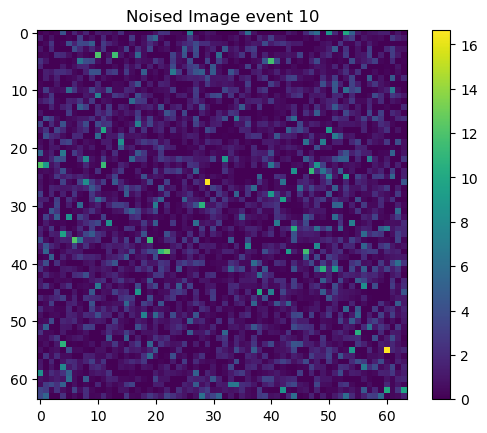

In [10]:
plt.imshow(noisy_image[0])
plt.colorbar()
plt.title(f"Noised Image event {testEvent}")
plt.show()

In [11]:
from Models.models_reduced_constkernels import Model

modtype = 'UNet_lite' # Change Model type here
model = Model(modtype, new_dim)
model = model.__getitem__()

if modtype == 'UNet2d':
    # Use 1st line for huggingface trained model
    # Use 2nd line for retrained model
    #trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
    trained_model_path = 'retrained_models_UNet2d/saturation=512/model_epoch_9.pt'

elif modtype == 'UNet_lite':
    trained_model_path = 'trained_models_lite/reduced_constkernels/model_epoch_9.h5' # Specify folder for which trained model here!

print('Trained Model Path: ', trained_model_path)
dummy_input = tf.zeros((1, new_dim[0], new_dim[1], 1), dtype=tf.float32)
dummy_time = tf.zeros((), dtype=tf.int32)
model((dummy_input, dummy_time))
print('Number of learnable params: ', model.count_params())

model.load_weights(trained_model_path)
print(model.summary()) # PRINT MODEL


Trained Model Path:  trained_models_lite/reduced_constkernels/model_epoch_9.h5


2024-07-29 13:12:37.422591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-29 13:12:37.433192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-07-29 13:12:37.487901: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied


Number of learnable params:  4950
Model: "u_net_lite_hls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding (Positi  multiple                 0         
 onalEncoding)                                                   
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 dense (Dense)               multiple                  5         
                                                                 
 conv2d (Conv2D)             multiple                  72        
                                                                 
 layer_normalization (LayerN  multiple                 16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)

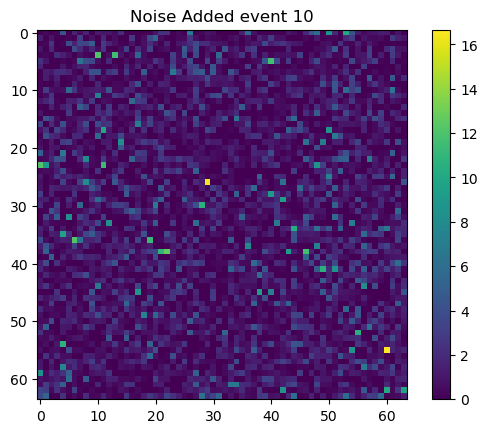

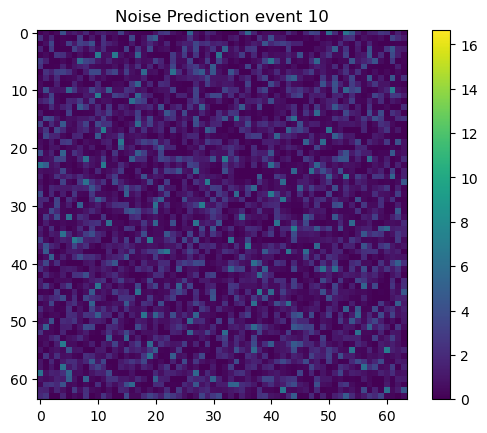

In [12]:
timestep = tf.convert_to_tensor(40)

if modtype == 'UNet2d':
    noise_pred = model([noisy_image, timestep], training=False)[0]
elif modtype == 'UNet_lite':
    noise_pred = model([noisy_image, timestep], training=False)



# Calculate the min and max values for setting the color scale
vmin = min(noise_pred.numpy().min(), noise.numpy().min())
vmax = max(noise_pred.numpy().max(), noise.numpy().max())


# Display the noise added
ims2 = plt.imshow(noise[0])
plt.colorbar(ims2)
plt.title(f"Noise Added event {testEvent}")
plt.show()

# Display the noise prediction
ims = plt.imshow(noise_pred[0], vmin=vmin, vmax=vmax) # Move prediction back to CPU for visualization
plt.colorbar(ims)
plt.title(f"Noise Prediction event {testEvent}")
plt.show()



In [13]:
de_noised = tf.nn.relu(noisy_image - noise_pred)

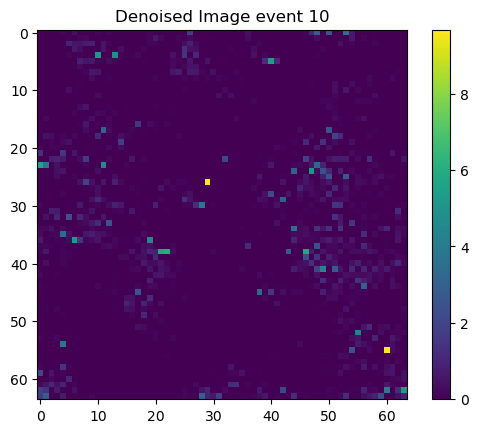

In [14]:
im = plt.imshow(de_noised[0])
plt.colorbar(im)
plt.title(f"Denoised Image event {testEvent}")
plt.show()

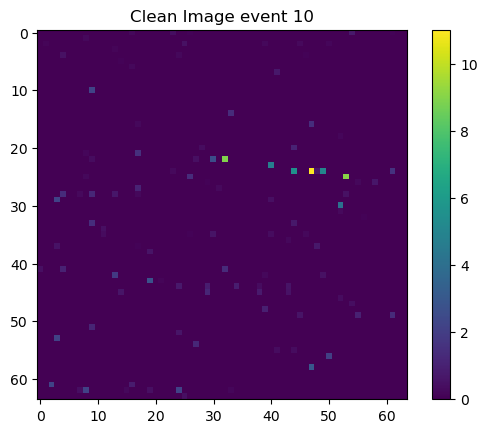

In [15]:
im2 = plt.imshow(clean_frames[testEvent])
plt.colorbar(im2)
plt.title(f"Clean Image event {testEvent}")
plt.show()

In [16]:
err = clean_frames[testEvent] - de_noised
print(f"MSE for event {testEvent}: {np.mean((err.numpy())**2)}")


MSE for event 10: 0.30727899074554443


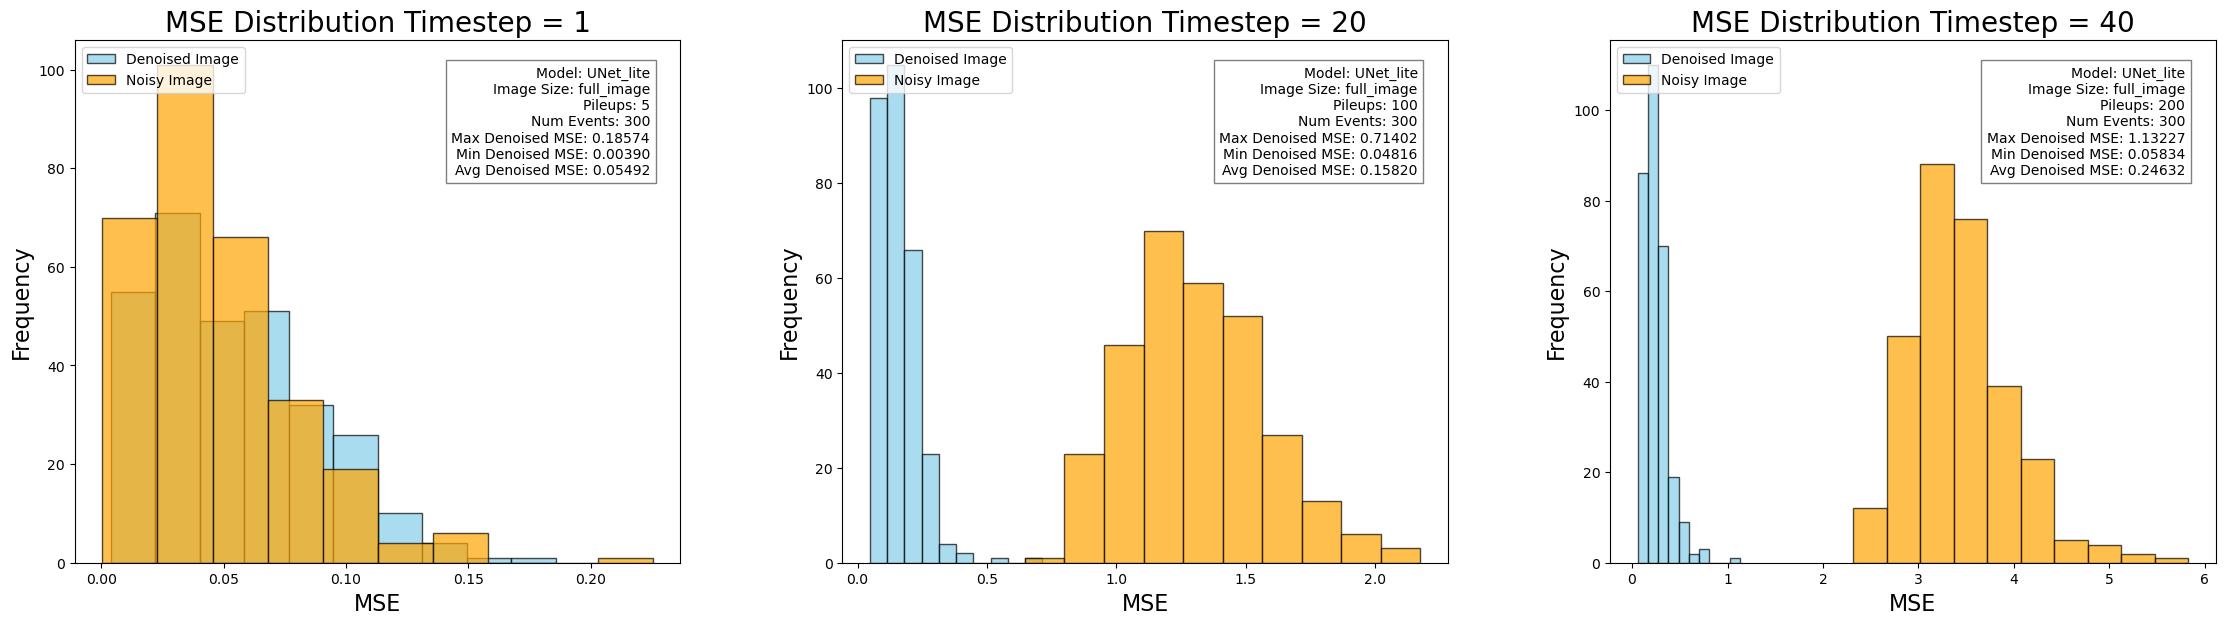

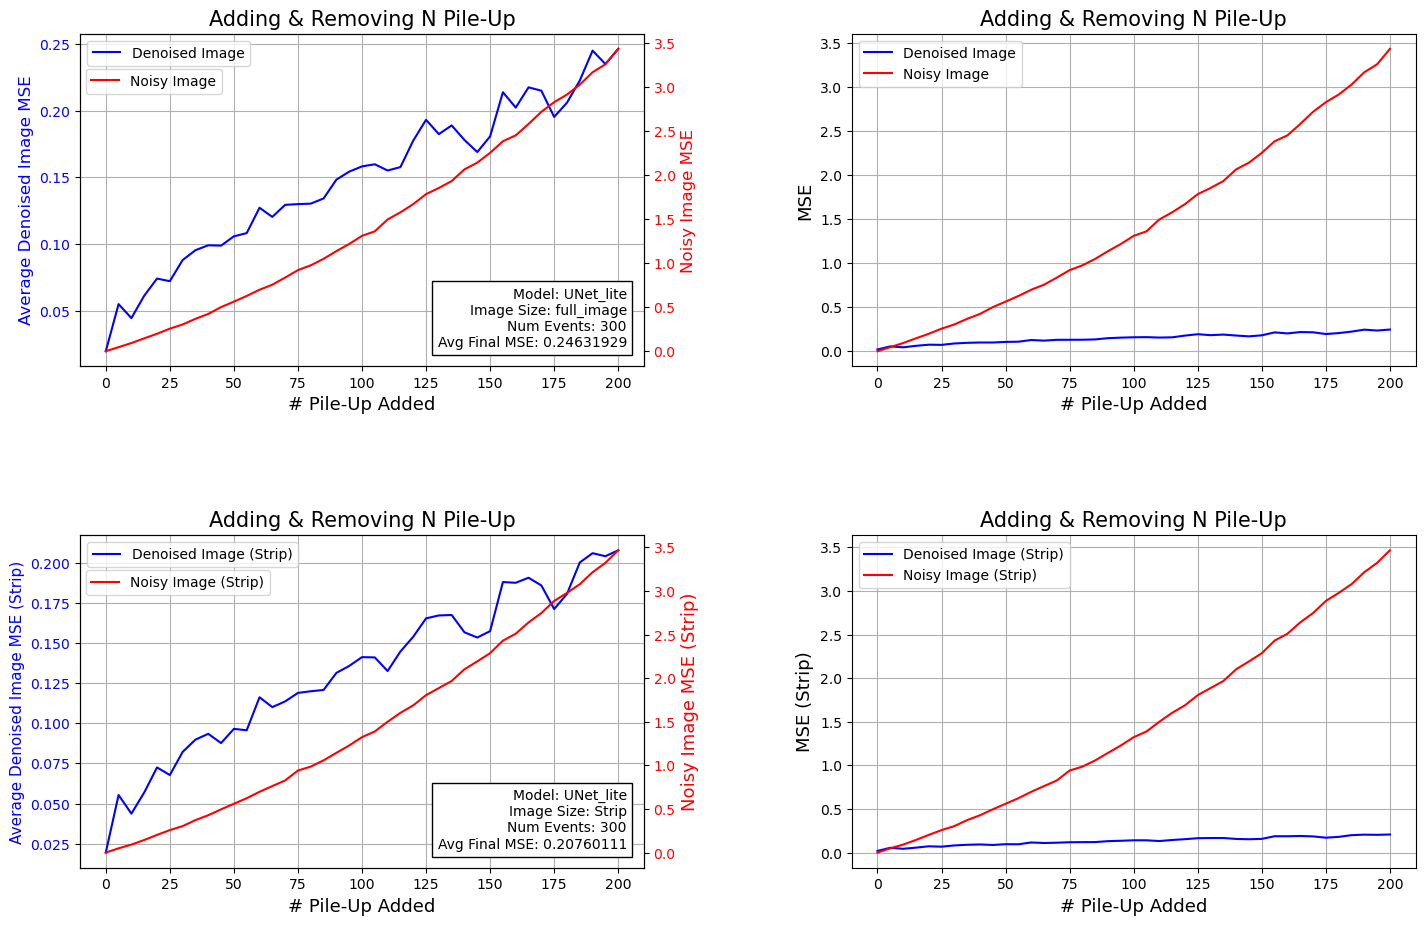

In [17]:
# Parameters
timesteps = np.linspace(0, 40, 41)  # Which timesteps to perform denoising at
num_events = end_idx - start_idx  # Number of trials where denoising process is performed and evaluated
batch_size = 100  # Adjust as needed
num_batches = num_events // batch_size

# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between denoised image and clean image
denoised_results_strip = np.zeros((len(timesteps), num_batches, batch_size))
noisy_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between noisy image and clean image
noisy_results_strip = np.zeros((len(timesteps), num_batches, batch_size))

# Define DataLoader for inference batches
inference_dataset = tf.data.Dataset.from_tensor_slices(clean_frames).batch(batch_size)

# Add a specific amount of noise at each timestep
for idx, timestep_value in enumerate(timesteps):  # pairs up values of timesteps (=timestep_value) with their indexes(=idx)

    # Run the denoising process a number of times
    for batch_idx, clean_batch in enumerate(inference_dataset):
        timestep = tf.convert_to_tensor(timestep_value)
        random_seed = np.random.randint(0, end_idx - start_idx)

        # Create noisy image and noise prediction
        noisy_images, noise = noise_scheduler.add_noise(
            clean_frame=clean_batch,
            noise_sample=pile_up,
            timestep=timestep,
            random_seed=random_seed,
            n_events=end_idx - start_idx
        )

        # Apply saturation value clipping and scaling
        noisy_images = tf.clip_by_value(noisy_images, 0, saturation_value)

        if modtype == 'UNet2d':
            noise_pred = model([noisy_images, timestep], training=False)[0]
        elif modtype == 'UNet_lite':
            noise_pred = model([noisy_images, timestep], training=False)

        de_noised = tf.nn.relu(noisy_images - noise_pred)

        # Calculate the difference between denoised image and clean image
        denoised_err = clean_batch - de_noised
        denoised_MSE = tf.reduce_mean(tf.square(denoised_err), axis=[1, 2, 3])
        denoised_results[idx, batch_idx] = denoised_MSE.numpy()
        denoised_MSE_strip = tf.reduce_mean(tf.square(denoised_err[:, MSE_y_start:MSE_y_end, :, :]), axis=[1, 2, 3])
        denoised_results_strip[idx, batch_idx] = denoised_MSE_strip.numpy()

        # Calculate the difference between noisy image and clean image
        noisy_err = clean_batch - noisy_images
        noisy_MSE = tf.reduce_mean(tf.square(noisy_err), axis=[1, 2, 3])
        noisy_results[idx, batch_idx] = noisy_MSE.numpy()
        noisy_MSE_strip = tf.reduce_mean(tf.square(noisy_err[:, MSE_y_start:MSE_y_end, :, :]), axis=[1, 2, 3])
        noisy_results_strip[idx, batch_idx] = noisy_MSE_strip.numpy()

# Calculate and plot average MSE vs. timestep
av_denoised_MSE = denoised_results.mean(axis=-1).mean(axis=-1)
av_noisy_MSE = noisy_results.mean(axis=-1).mean(axis=-1)
av_denoised_MSE_strip = denoised_results_strip.mean(axis=-1).mean(axis=-1)
av_noisy_MSE_strip = noisy_results_strip.mean(axis=-1).mean(axis=-1)

# Plot histograms for selected timesteps
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1x3 grid for 3 selected timesteps

for plot_idx, idx in enumerate([1, len(timesteps) // 2, -1]): # Select only the 2nd, middle, and last timesteps
    timestep_value = timesteps[idx]
    ax = axes[plot_idx]  # Determine subplot position

    # Plot histogram for denoised results at each selected timestep
    denoised_mses_bins = np.linspace(np.min(denoised_results[idx]), np.max(denoised_results[idx]), 11)
    ax.hist(denoised_results[idx].flatten(), bins=denoised_mses_bins, color='skyblue', alpha=0.7, edgecolor='black', label='Denoised Image')

    # Plot histogram for noisy results at each selected timestep on same plot
    noisy_mses_bins = np.linspace(np.min(noisy_results[idx]), np.max(noisy_results[idx]), 11)
    ax.hist(noisy_results[idx].flatten(), bins=noisy_mses_bins, color='orange', alpha=0.7, edgecolor='black', label='Noisy Image')
    ax.set_title(f'MSE Distribution Timestep = {int(timestep_value)}', fontsize=20)
    ax.set_xlabel('MSE', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.legend(loc='upper left')

    # Adding text box with statistics
    textstr = '\n'.join((
        f'Model: {modtype}',
        f'Image Size: {strip_size}',
        f'Pileups: {int(timestep_value * 5)}',
        f'Num Events: {num_events}',
        f'Max Denoised MSE: {np.max(denoised_results[idx]):.5f}',
        f'Min Denoised MSE: {np.min(denoised_results[idx]):.5f}',
        f'Avg Denoised MSE: {av_denoised_MSE[idx]:.5f}'
    ))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout(pad=7)
plt.show()

# Calculate and plot average MSE vs. level of noise added
if strip_size == 'full_image':
    fig, axs = plt.subplots(2, 2, figsize=(16, 11))
    plot_pos1 = (0, 0)
    plot_pos2 = (0, 1)

elif strip_size == 'strip':
    fig, axs = plt.subplots(1, 2, figsize=(16, 5.5))
    plot_pos1 = (0,)
    plot_pos2 = (1,)


# Adding text box with final MSE val
textbox1 = '\n'.join((
    f'Model: {modtype}',
    f'Image Size: {strip_size}',
    f'Num Events: {num_events}',
    f'Avg Final MSE: {av_denoised_MSE[-1]:.8f}'
))

textbox2 = '\n'.join((
    f'Model: {modtype}',
    f'Image Size: Strip',
    f'Num Events: {num_events}',
    f'Avg Final MSE: {av_denoised_MSE_strip[-1]:.8f}'
))

# Plot both on same graph with different axes
axs[plot_pos1].plot(timesteps*5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[plot_pos1].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
axs[plot_pos1].set_xlabel('# Pile-Up Added', fontsize=13)
axs[plot_pos1].set_ylabel('Average Denoised Image MSE', color='blue', fontsize=12)
axs[plot_pos1].tick_params(axis='y', labelcolor='blue')
axs[plot_pos1].grid(True)
axs[plot_pos1].legend(loc='upper left')

axs[plot_pos1] = axs[plot_pos1].twinx()
axs[plot_pos1].plot(timesteps*5, av_noisy_MSE, linestyle='-', color='red', label='Noisy Image')
axs[plot_pos1].set_ylabel('Noisy Image MSE', color='red', fontsize=12)
axs[plot_pos1].tick_params(axis='y', labelcolor='red')
axs[plot_pos1].legend(loc=(0.01,0.82))
axs[plot_pos1].text(0.97, 0.05, textbox1, transform=axs[plot_pos1].transAxes, fontsize=10,
               verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(facecolor='white', alpha=1))

# Plot both on same graph with same axis
axs[plot_pos2].plot(timesteps*5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[plot_pos2].plot(timesteps*5, av_noisy_MSE, linestyle='-', color='red', label='Noisy Image')
axs[plot_pos2].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
axs[plot_pos2].set_xlabel('# Pile-Up Added', fontsize=13)
axs[plot_pos2].set_ylabel('MSE', fontsize=13)
axs[plot_pos2].legend(loc='upper left')
axs[plot_pos2].grid(True)


if strip_size == 'full_image':
    # Plot for the strip section of the full image
    axs[1, 0].plot(timesteps*5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image (Strip)')
    axs[1, 0].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
    axs[1, 0].set_xlabel('# Pile-Up Added', fontsize=13)
    axs[1, 0].set_ylabel('Average Denoised Image MSE (Strip)', color='blue', fontsize=11)
    axs[1, 0].tick_params(axis='y', labelcolor='blue')
    axs[1, 0].legend(loc='upper left')
    axs[1, 0].grid(True)
    axs[1, 0].text(0.97, 0.05, textbox2, transform=axs[1, 0].transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=1))

    axs[1, 0] = axs[1, 0].twinx()
    axs[1, 0].plot(timesteps*5, av_noisy_MSE_strip, linestyle='-', color='red', label='Noisy Image (Strip)')
    axs[1, 0].set_ylabel('Noisy Image MSE (Strip)', color='red', fontsize=13)
    axs[1, 0].tick_params(axis='y', labelcolor='red')
    axs[1, 0].legend(loc=(0.01,0.82))

    # Plot both on same graph with same axis for the strip
    axs[1, 1].plot(timesteps*5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image (Strip)')
    axs[1, 1].plot(timesteps*5, av_noisy_MSE_strip, linestyle='-', color='red', label='Noisy Image (Strip)')
    axs[1, 1].set_title(f'Adding & Removing N Pile-Up', fontsize=15)
    axs[1, 1].set_xlabel('# Pile-Up Added', fontsize=13)
    axs[1, 1].set_ylabel('MSE (Strip)', fontsize=13)
    axs[1, 1].legend()
    axs[1, 1].grid(True)

fig.tight_layout(pad=7)  # Adjust subplots to fit into figure area.
plt.show()

The avg MSE for the strip (y=26 -> y=38) across 300 events is: 0.21682848814254005
The avg MSE for the full_image across 300 events is: 0.25744559892763696
0.0000 % of events reached the saturation energy of 512 GeV


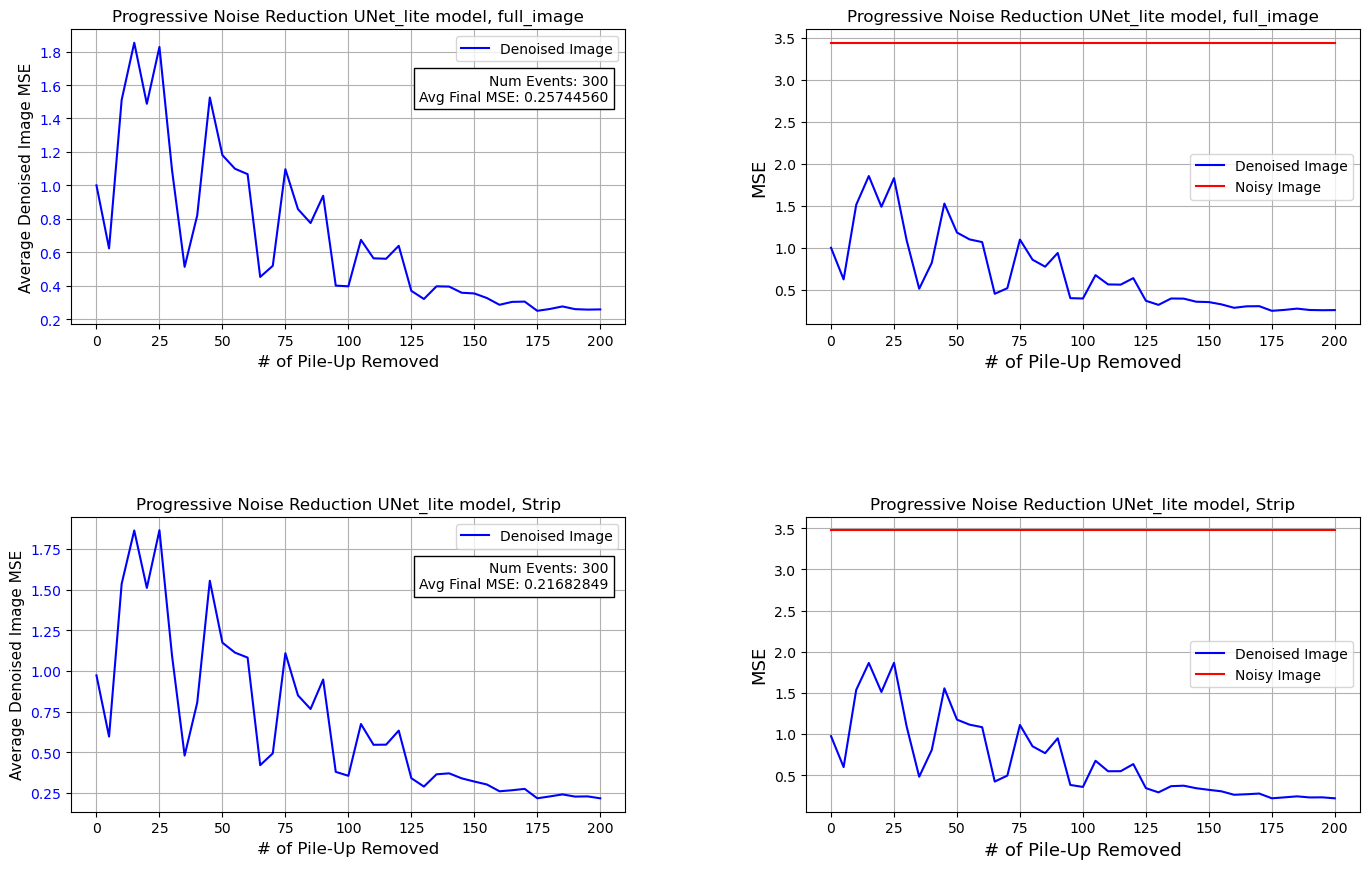

In [18]:
# Evaluate the model at different timesteps
timesteps = np.arange(0, 41, 1)  # Which timesteps to perform denoising at
num_events = end_idx - start_idx  # Number of trials
batch_size = 100  # Define batch size
num_batches = num_events // batch_size

maxTimestep = tf.convert_to_tensor(40)

# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps), num_batches, batch_size))  # For MSEs between denoised image and clean image
denoised_results_strip = np.zeros((len(timesteps), num_batches, batch_size))
noisy_results = np.zeros((num_batches, batch_size))  # For MSEs between noisy image and clean image
noisy_results_strip = np.zeros((num_batches, batch_size))

inference_dataset = tf.data.Dataset.from_tensor_slices(clean_frames).batch(batch_size)

for idx, timestep_value in enumerate(timesteps):
    timestep = tf.convert_to_tensor(timestep_value)

    for batch_idx, clean_batch in enumerate(inference_dataset):
        random_seed = np.random.randint(0, end_idx - start_idx)
        # Generate the noisy image at maxTimestep (200 pile-ups)
        noisy_images, noise = noise_scheduler.add_noise(
            clean_frame=clean_batch, 
            noise_sample=pile_up, 
            timestep=maxTimestep, 
            random_seed=random_seed, 
            n_events=end_idx - start_idx
        )

        # Apply saturation value clipping and scaling
        noisy_images = tf.clip_by_value(noisy_images, 0, saturation_value)

        if modtype == 'UNet2d':
            noise_pred = model([noisy_images, timestep], training=False)
        elif modtype == 'UNet_lite':
            noise_pred = model([noisy_images, timestep], training=False)

        de_noised = tf.nn.relu(noisy_images - noise_pred)
        
        # Calculate the difference between denoised image and clean image
        denoised_err = clean_batch - de_noised
        denoised_MSE = tf.reduce_mean(tf.square(denoised_err), axis=[1, 2, 3])
        denoised_results[idx, batch_idx] = denoised_MSE.numpy()
        denoised_MSE_strip = tf.reduce_mean(tf.square(denoised_err[:, MSE_y_start:MSE_y_end, :, :]), axis=[1, 2, 3])
        denoised_results_strip[idx, batch_idx] = denoised_MSE_strip.numpy()

        # Calculate the difference between noisy image and clean image
        noisy_err = clean_batch - noisy_images
        noisy_MSE = tf.reduce_mean(tf.square(noisy_err), axis=[1, 2, 3])
        noisy_results[batch_idx] = noisy_MSE.numpy()
        noisy_MSE_strip = tf.reduce_mean(tf.square(noisy_err[:, MSE_y_start:MSE_y_end, :, :]), axis=[1, 2, 3])
        noisy_results_strip[batch_idx] = noisy_MSE_strip.numpy()

        if timestep_value == 50 and batch_idx == 0:  # Look at how much pileup removal in the timestep value
            fig, axs = plt.subplots(1, 4, figsize=(32, 6))

            im0 = axs[0].imshow(noise_pred[testEvent].numpy().squeeze())  # Move prediction back to CPU for visualization
            axs[0].set_title(f"Noise Prediction for event {batch_idx * batch_size}")
            fig.colorbar(im0, ax=axs[0])

            im1 = axs[1].imshow(noisy_images[testEvent].numpy().squeeze())
            axs[1].set_title(f"Noisy Image for Event {batch_idx * batch_size}")
            fig.colorbar(im1, ax=axs[1])

            im2 = axs[2].imshow(de_noised[testEvent].numpy().squeeze())
            axs[2].set_title(f"Denoised Image for Event {batch_idx * batch_size}")
            fig.colorbar(im2, ax=axs[2])

            im3 = axs[3].imshow(clean_batch[testEvent].numpy().squeeze())
            axs[3].set_title(f"Clean Image for Event {batch_idx * batch_size}")
            fig.colorbar(im3, ax=axs[3])
            plt.show()

            # Print the maximum pixel value across the entire noisy image
            max_pixel_value = noisy_images.numpy().max()
            print(f"The maximum pixel value in the noisy image for Event {batch_idx * batch_size} is: {max_pixel_value}")

# Calculate and plot average MSE vs. timestep
av_denoised_MSE = denoised_results.mean(axis=-1).mean(axis=-1)
av_noisy_MSE = noisy_results.mean(axis=-1).mean(axis=-1)

av_denoised_MSE_strip = denoised_results_strip.mean(axis=-1).mean(axis=-1)
av_noisy_MSE_strip = noisy_results_strip.mean(axis=-1).mean(axis=-1)

if strip_size == 'full_image':
    fig, axs = plt.subplots(2, 2, figsize=(16, 11))
    plot_pos1 = 0, 0
    plot_pos2 = 0, 1

elif strip_size == 'strip':
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    plot_pos1 = 0
    plot_pos2 = 1

# Adding text box with statistics
textbox3 = '\n'.join((
    f'Num Events: {num_events}',
    f'Avg Final MSE: {av_denoised_MSE[-1]:.8f}'
))

textbox4 = '\n'.join((
    f'Num Events: {num_events}',
    f'Avg Final MSE: {av_denoised_MSE_strip[-1]:.8f}'
))

axs[plot_pos1].plot(timesteps * 5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[plot_pos1].set_title(f'Progressive Noise Reduction {modtype} model, {strip_size}', fontsize=12)
axs[plot_pos1].set_xlabel('# of Pile-Up Removed', fontsize=12)
axs[plot_pos1].set_ylabel('Average Denoised Image MSE', fontsize=11)
axs[plot_pos1].tick_params(axis='y', labelcolor='blue')
axs[plot_pos1].grid(True)
axs[plot_pos1].legend(loc='upper right')
axs[plot_pos1].text(0.97, 0.85, textbox3, transform=axs[plot_pos1].transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=1))

axs[plot_pos2].plot(timesteps * 5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[plot_pos2].plot(timesteps * 5, [av_noisy_MSE] * len(timesteps), linestyle='-', color='red', label='Noisy Image')
axs[plot_pos2].set_title(f'Progressive Noise Reduction {modtype} model, {strip_size}', fontsize=12)
axs[plot_pos2].set_xlabel('# of Pile-Up Removed', fontsize=13)
axs[plot_pos2].set_ylabel('MSE', fontsize=13)
axs[plot_pos2].legend()
axs[plot_pos2].grid(True)

if strip_size == 'full_image':
    axs[1, 0].plot(timesteps * 5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image')
    axs[1, 0].set_title(f'Progressive Noise Reduction {modtype} model, Strip', fontsize=12)
    axs[1, 0].set_xlabel('# of Pile-Up Removed', fontsize=12)
    axs[1, 0].set_ylabel('Average Denoised Image MSE', fontsize=11)
    axs[1, 0].tick_params(axis='y', labelcolor='blue')
    axs[1, 0].grid(True)
    axs[1, 0].legend(loc='upper right')
    axs[1, 0].text(0.97, 0.85, textbox4, transform=axs[1, 0].transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=1))

    axs[1, 1].plot(timesteps * 5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image')
    axs[1, 1].plot(timesteps * 5, [av_noisy_MSE_strip] * len(timesteps), linestyle='-', color='red', label='Noisy Image')
    axs[1, 1].set_title(f'Progressive Noise Reduction {modtype} model, Strip', fontsize=12)
    axs[1, 1].set_xlabel('# of Pile-Up Removed', fontsize=13)
    axs[1, 1].set_ylabel('MSE', fontsize=13)
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    print(f'The avg MSE for the strip (y={MSE_y_start} -> y={MSE_y_end}) across {num_events} events is:', av_denoised_MSE_strip[-1])

print(f'The avg MSE for the {strip_size} across {num_events} events is:', av_denoised_MSE[-1])
print(f'{(np.sum(noisy_max_bin == saturation_value) / noisy_max_bin.size) * 100:.4f} % of events reached the saturation energy of {saturation_value} GeV')
fig.tight_layout(pad=9)  # Adjust subplots to fit into figure area.
plt.show()